# Système d'attente Waterfall

## Modélisation du système Waterfall

Nous modélisons le système Waterfall de la manière suivante :

- Une file d'attente $F_1$ de paramètre $ M/M/K $ représentant l'attente pour les tests.

- Une file d'attente $F_2$ de paramètre $ G/M/1 $ représentant l'attente pour l'envoie vers le front-end des résultats de la file précédente. L'entrée est de processus général G et non poisson M car $F_2$ prend en entrée les agents sortant de $F_1$, nous ne sommes donc pas sur un "vrai" processus de Poisson.

Schématiquement, nous avons l'architecture suivante pour notre système d'attente

   [Entrée des agents] -> $F_1$ ($M/M/K$) -> $F_2$ ($G/M/1$) -> [Sortie des agents] 


Nous définissons de plus les paramètres suivants pour décrire le système:

- $ \lambda $: Taux d'arrivé des utilisateurs dans la file d'attente $ F_1 $, autrement dit dans le système d'attente Waterfall global (selon un processus de Poisson)
- $ \mu_1 $: Taux de service de la file d'attente $ F_1 $ (selon un processus de Poisson)
- $ \mu_2 $: Taux de service de la file d'attente $ F_2 $ (selon un processus de Poisson)
- $ K $: Nombres de serveurs pour la file d'attente $F_1$

Nous considérons en premier lieu que les files d'attentes ont une capacité infinie.

## Code Python de simulation

In [319]:
import numpy as np
import pandas as pd

class Wline():

    def __init__(self, size=None, policy=(lambda x: 0)):
        self.size = size
        self.next = policy
        self.queue = []

    def populate(self, queue):
        self.queue = queue
    
    def pop(self):
        pop_ix = self.next(self.queue)
        pop_val = None
        
        if -1 < pop_ix < len(self.queue):
            pop_val = self.queue[pop_ix]
            self.queue.pop(pop_ix)
            
        return pop_val

class InService():
    
    def __init__(self, nb=1, dist=None, depart_col='t_depart_sys'):
        self.nb = nb
        self.server = [None]*nb
        self.dist = dist
        self.depart_col = depart_col
        
    def full(self):
        return not (None in self.server)
        
    def leaving(self, tops):
        
        agent_id = None
        
        if not self.full():
            # Find first available server
            srv_ix = self.server.index(None) 
        
        else:
            # Extract agent with earliest departure in this stage
            agent_id = tops.loc[self.server, self.depart_col].astype(float).idxmin()
            srv_ix = self.server.index(agent_id)
        
        return srv_ix, agent_id

class Waterfall():
    
    def __init__(self,
                 arval_dist,
                 test_srv_dist,
                 front_srv_dist,
                 test_servers_nb,
                 front_servers_nb,
                 test_queue_size=None,
                 front_queue_size=None,
                 test_policy=lambda x: 0,
                 front_policy=lambda x: 0,
                 test_size=100):

        # Distributions
        self.arval_dist = arval_dist
        self.test_srv_dist = test_srv_dist
        self.front_srv_dist = front_srv_dist
        
        # Servers and queue sizes
        self.test_servers_nb = test_servers_nb
        self.front_servers_nb = front_servers_nb
        
        self.test_queue_size = test_queue_size if test_queue_size else test_size
        self.front_queue_size = front_queue_size if front_queue_size else test_size
        
        self.test_size = test_size

        # Waiting lines
        self.wline_test = Wline(size=test_queue_size, policy=test_policy)
        self.wline_front = Wline(size=front_queue_size, policy=front_policy)
        
        # Servers with correct departure field references
        self.test_inservice = InService(
            nb=test_servers_nb, 
            dist=test_srv_dist,
            depart_col='t_depart_test'
        )
        
        self.front_inservice = InService(
            nb=front_servers_nb, 
            dist=front_srv_dist,
            depart_col='t_depart_sys'
        )
        
        # Dataframe initialization
        column_names = [
            't_arval_test_queue',
            't_arval_test_srv',
            't_depart_test',
            't_arval_front_queue',
            't_arval_front_srv',
            't_depart_sys'
        ]
        
        self.tops = pd.DataFrame(
            np.empty((test_size, len(column_names)), dtype=object), 
            columns=column_names
        )
        
    # -------------------------------------------------
    def pretreat(self):
        """Generate arrival times for TEST queue."""
        t_inter = self.arval_dist(size=(self.test_size))
        self.tops.loc[0, 't_arval_test_queue'] = t_inter[0]
        
        for i in range(1, self.test_size):
            self.tops.loc[i, 't_arval_test_queue'] = \
                self.tops.loc[i-1, 't_arval_test_queue'] + t_inter[i]

    # -------------------------------------------------
    def run(self):
        """Simulate test queue → test servers → front queue → front servers."""
        
        # ==============================
        #     1. TEST QUEUE STAGE
        # ==============================
        self.wline_test.queue = [0]
        nxt = 1
        
        while nxt < self.test_size:
            agent = self.wline_test.pop()
            
            if agent is not None:
                # server arrival
                self.tops.loc[agent, 't_arval_test_srv'] = \
                    self.tops.loc[agent, 't_arval_test_queue']

                # find server
                srv_ix, dept_ag = self.test_inservice.leaving(self.tops)
                self.test_inservice.server[srv_ix] = agent

                # if server is busy, update arrival time
                if dept_ag is not None:
                    if self.tops.loc[agent, 't_arval_test_queue'] < \
                       self.tops.loc[dept_ag, 't_depart_test']:
                        self.tops.loc[agent, 't_arval_test_srv'] = \
                            self.tops.loc[dept_ag, 't_depart_test']

                # departure from test stage
                self.tops.loc[agent, 't_depart_test'] = \
                    self.tops.loc[agent, 't_arval_test_srv'] + self.test_inservice.dist()
            
            # evaluate admission of next arrival
            in_system = (self.tops.loc[0:nxt-1, 't_depart_test'] > 
                         self.tops.loc[nxt, 't_arval_test_queue']).sum()

            if self.test_queue_size is not None and \
               in_system >= self.test_queue_size + self.test_inservice.nb:
                # blocked at test
                self.tops.loc[nxt, 't_depart_test'] = -1
            else:
                self.wline_test.queue.append(nxt)

            nxt += 1
        
        
        # ==============================
        #     2. FRONT QUEUE STAGE
        # ==============================
        
        entering = self.tops[self.tops['t_depart_test'] != -1].index
        if len(entering) == 0:
            return
        
        # Initialize
        entering = list(entering)
        first = entering[0]

        self.wline_front.queue = [first]
        self.tops.loc[first, 't_arval_front_queue'] = self.tops.loc[first, 't_depart_test']
        
        pos = 1
        
        while pos < len(entering):
            agent = self.wline_front.pop()
            
            if agent is not None:
                self.tops.loc[agent, 't_arval_front_srv'] = \
                    self.tops.loc[agent, 't_arval_front_queue']

                srv_ix, dept_ag = self.front_inservice.leaving(self.tops)
                self.front_inservice.server[srv_ix] = agent

                if dept_ag is not None:
                    if self.tops.loc[agent, 't_arval_front_queue'] < \
                       self.tops.loc[dept_ag, 't_depart_sys']:
                        self.tops.loc[agent, 't_arval_front_srv'] = \
                            self.tops.loc[dept_ag, 't_depart_sys']

                # final departure
                self.tops.loc[agent, 't_depart_sys'] = \
                    self.tops.loc[agent, 't_arval_front_srv'] + self.front_inservice.dist()

            
            next_agent = entering[pos]
            self.tops.loc[next_agent, 't_arval_front_queue'] = \
                self.tops.loc[next_agent, 't_depart_test']

            in_front = (self.tops.loc[entering[:pos], 't_depart_sys'] > 
                        self.tops.loc[next_agent, 't_arval_front_queue']).sum()

            if self.front_queue_size is not None and \
               in_front >= self.front_queue_size + self.front_inservice.nb:
                self.tops.loc[next_agent, 't_depart_sys'] = -1
            else:
                self.wline_front.queue.append(next_agent)

            pos += 1

    # -------------------------------------------------
    def posttreat(self):
        """Compute final stats and classify customers."""
        
        # which customers were blocked
        self.tops['blocked_test'] = self.tops['t_depart_test'] == -1
        self.tops['blocked_front'] = (~self.tops['blocked_test']) & (self.tops['t_depart_sys'] == -1)

        # arrival times may be missing for blocked front customers
        self.tops['t_depart_sys'] = (
    pd.to_numeric(self.tops['t_depart_sys'], errors='coerce').fillna(-1))

        # ==========================
        # Waiting times
        # ==========================
        self.tops['t_wait_test'] = np.where(
            self.tops['t_depart_test'] == -1, 
            0,
            self.tops['t_arval_test_srv'] - self.tops['t_arval_test_queue']
        )

        self.tops['t_wait_front'] = np.where(
            (self.tops['t_depart_sys'] == -1) | self.tops['blocked_test'],
            0,
            self.tops['t_arval_front_srv'] - self.tops['t_arval_front_queue']
        )

        # ==========================
        # Service times
        # ==========================
        self.tops['t_srv_test'] = np.where(
            self.tops['t_depart_test'] == -1, 
            0,
            self.tops['t_depart_test'] - self.tops['t_arval_test_srv']
        )

        self.tops['t_srv_front'] = np.where(
            self.tops['t_depart_sys'] == -1,
            0,
            self.tops['t_depart_sys'] - self.tops['t_arval_front_srv']
        )

        # ==========================
        # Total time in system
        # ==========================
        self.tops['t_sojourn'] = np.where(
            self.tops['t_depart_sys'] == -1, 
            0,
            self.tops['t_depart_sys'] - self.tops['t_arval_test_queue']
        )

    # -------------------------------------------------
    def timeline(self, t_delation=2):
        """Full-system timeline."""
        
        tmax = self.tops['t_depart_sys'].replace(-1, np.nan).max()
        t_range = np.linspace(0, tmax, t_delation * self.test_size)

        cols = [
            'in_test_queue', 'in_test_srv',
            'in_front_queue', 'in_front_srv',
            'in_system'
        ]

        timeline = pd.DataFrame(index=t_range, columns=cols)

        for t in t_range:

            timeline.loc[t, 'in_test_queue'] = \
                ((t >= self.tops['t_arval_test_queue']) &
                 (t <= self.tops['t_arval_test_srv'])).sum()

            timeline.loc[t, 'in_test_srv'] = \
                ((t >= self.tops['t_arval_test_srv']) &
                 (t <= self.tops['t_depart_test'])).sum()

            timeline.loc[t, 'in_front_queue'] = \
                ((t >= self.tops['t_arval_front_queue']) &
                 (t <= self.tops['t_arval_front_srv'])).sum()

            timeline.loc[t, 'in_front_srv'] = \
                ((t >= self.tops['t_arval_front_srv']) &
                 (t <= self.tops['t_depart_sys'])).sum()

            timeline.loc[t, 'in_system'] = \
                ((t >= self.tops['t_arval_test_queue']) &
                 (t <= self.tops['t_depart_sys'])).sum()

        stats = {
            'mean_wait_test': self.tops['t_wait_test'].mean(),
            'mean_wait_front': self.tops['t_wait_front'].mean(),
            'mean_srv_test': self.tops['t_srv_test'].mean(),
            'mean_srv_front': self.tops['t_srv_front'].mean(),
            'blocked_at_test': self.tops['blocked_test'].mean(),
            'blocked_at_front': self.tops['blocked_front'].mean(),
            'mean_sojourn': self.tops['t_sojourn'].mean(),
            'test_busy_fraction': (timeline['in_test_srv'] == self.test_servers_nb).mean(),
            'front_busy_fraction': (timeline['in_front_srv'] == self.front_servers_nb).mean()
        }

        return timeline, pd.DataFrame.from_dict(stats, orient='index', columns=['value'])
    
    # -------------------------------------------------
    def simulate(self):
        self.pretreat()
        self.run()
        self.posttreat()

def plot_bench(bench):
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))

    # Define columns to plot
    counts = [
        'in_system',                        # total in system
        ['in_test_queue', 'in_front_queue'], # queues
        ['in_test_srv', 'in_front_srv']     # services
    ]

    labels = ['System', 'Queue', 'Service']
    colors = [
        ['black'],                     # total system
        ['blue', 'green'],             # test queue = blue, front queue = green
        ['red', 'orange']              # test service = red, front service = orange
    ]
    titles = ['Évolution du nombre total d\'agents dans le système', 'Évolution du nombre d\'agents en attente', 'Évolution du nombre d\'agents en service']

    for i in range(3):
        if isinstance(counts[i], list):
            # multiple lines
            for j, col in enumerate(counts[i]):
                bench.plot(y=col, use_index=True, ax=axes[i], linewidth=1.5,
                           drawstyle='steps-mid', color=colors[i][j],
                           label=col)
            axes[i].legend()
        else:
            # single line
            bench.plot(y=counts[i], use_index=True, ax=axes[i], linewidth=1.5,
                       drawstyle='steps-mid', color=colors[i][0])
        axes[i].set_title(titles[i])
        axes[i].set_ylabel(f'Agent number in {labels[i]}')
        axes[i].set_xlabel('Time')
        axes[i].set_ylim(0, max(bench['in_system']+1))

    plt.tight_layout()
    plt.show()

# Analyse du système d'attente



## Cas avec files d'attentes infinies

On s'intéresse en premier lieu au système Waterfall en posant l'hypothèse de que les deux files d'attentes $F_1$ et $F_2$ disposent d'une FIFO infinie. Il est donc impossible de se voir rejeter l'accès au système d'attente.

### Première simulation: cas stable
Nous effectuons une première simulation avec les paramètres suivants:
- $ \lambda $ = 4
- $ \mu_1 $ = 2
- $ \mu_2 $ = 6
- $ K $ = 3

Ayant $\lambda$ < $\mu_1$ et $\lambda$ < $\mu_2$, nous nous attendons à voir une stabilité du système global, car le taux d'entrée des agents est inférieur au taux de service des deux files d'attentes $F_1$ et $F_2$ de notre système d'attente.
Nous sommes donc censé avoir un taux de charge inférieur à 1.
La simulation étudie le comportement de notre système dans le temps pour une entrée d'un total de 500 agents.

In [364]:
# Waiting system parameters
lambdaa = 4
mu_1 = 2
mu_2 = 6
k = 3

arval_dist = lambda size : rng.exponential(1./lambdaa, size=size)
test_srv_dist = lambda : rng.exponential(1./mu_1)
front_srv_dist = lambda : rng.exponential(1./mu_2)

agent_nb = 500

waterfall = Waterfall(arval_dist,
                 test_srv_dist,
                 front_srv_dist,
                 k,
                 1,
                 test_queue_size=None,
                 front_queue_size=None,
                 test_policy=lambda x:0,
                 front_policy=lambda x: 0,
                 test_size=agent_nb)

In [365]:
waterfall.simulate()
bench, stats = waterfall.timeline()
stats

,value
mean_wait_test,0.749556
mean_wait_front,1.824091
mean_srv_test,0.538685
mean_srv_front,0.166892
blocked_at_test,0.000000
blocked_at_front,0.000000
mean_sojourn,3.276648
test_busy_fraction,0.709000
front_busy_fraction,0.766000


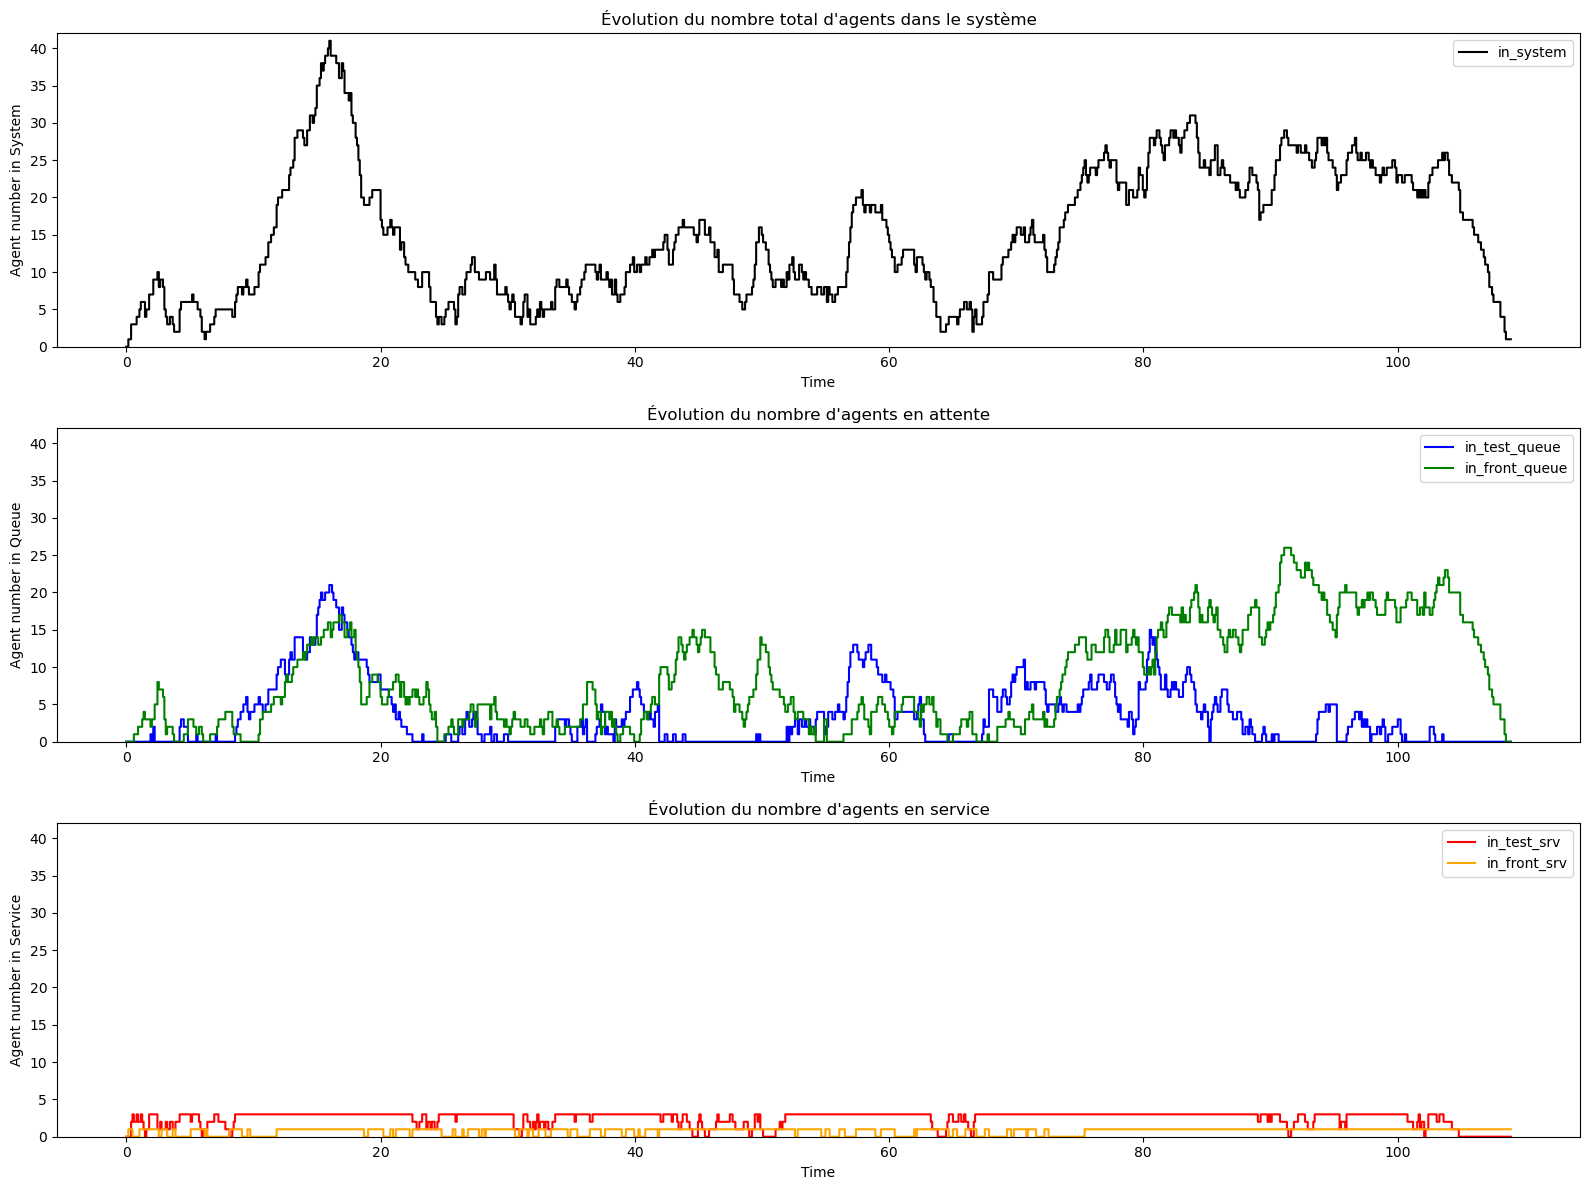

In [366]:
plot_bench(bench)

Selon les graphiques plus haut, nous observons effectivement la stabilité du système au global. 

Le premier graphique nous montre que le nombre maximum d'agents dans le système converge bien vers une valeur entière et qu'il n'y a pas d'"explosion" des files d'attentes s'accumulant sur le temps (les pics finissent toujours par redescendre).

Le deuxième graphique nous montre plus en détail l'occupation des files d'attentes, nous pouvons observer que la file d'attente de $F_1$ (courbe 'in_test_queue') n'est jamais occupée, ce qui montre qu'elle ne souffre d'aucun goulot d'étranglement de par le faible nombre d'arrivés d'agents par rapport au taux de service et au nombre de serveur K.

La file d'attente de $F_2$ en revanche contient significativement plus d'agents en attente, ce qui est logique compte tenue du fait qu'elle ne dispose que d'un seul serveur de traitement et qu'elle prend en entrée les sorties de la file $F_2$ disposant d'un taux de service naturellement plus élevé car disposant de $K$ serveurs.

### Deuxième simulation: instabilité de la file $F_1$
Nous effectuons une deuxième simulation avec les paramètres suivants:
- $ \lambda $ = 8
- $ \mu_1 $ = 2
- $ \mu_2 $ = 10
- $ K $ = 3

Ici l'objectif est d'observer le comportement du système dans le cas où la première file $F_1$ agit comme un goulot d'étranglement évident. Cela se traduit par le fait d'avoir $K* \mu_1 \leq \lambda$.

Autrement dit, le taux de charge de la file $F_1$ $\rho_1 = \frac{\lambda}{K * \mu_1}$ devient supérieur ou égal à 1.

In [370]:
# Waiting system parameters
lambdaa = 8
mu_1 = 2
mu_2 = 10
k = 3

arval_dist = lambda size : rng.exponential(1./lambdaa, size=size)
test_srv_dist = lambda : rng.exponential(1./mu_1)
front_srv_dist = lambda : rng.exponential(1./mu_2)

agent_nb = 500

waterfall = Waterfall(arval_dist,
                 test_srv_dist,
                 front_srv_dist,
                 k,
                 1,
                 test_queue_size=None,
                 front_queue_size=None,
                 test_policy=lambda x:0,
                 front_policy=lambda x: 0,
                 test_size=agent_nb)

In [371]:
waterfall.simulate()
bench, stats = waterfall.timeline()
stats

,value
mean_wait_test,6.856112
mean_wait_front,0.782008
mean_srv_test,0.498166
mean_srv_front,0.101160
blocked_at_test,0.000000
blocked_at_front,0.000000
mean_sojourn,8.222737
test_busy_fraction,0.963000
front_busy_fraction,0.597000


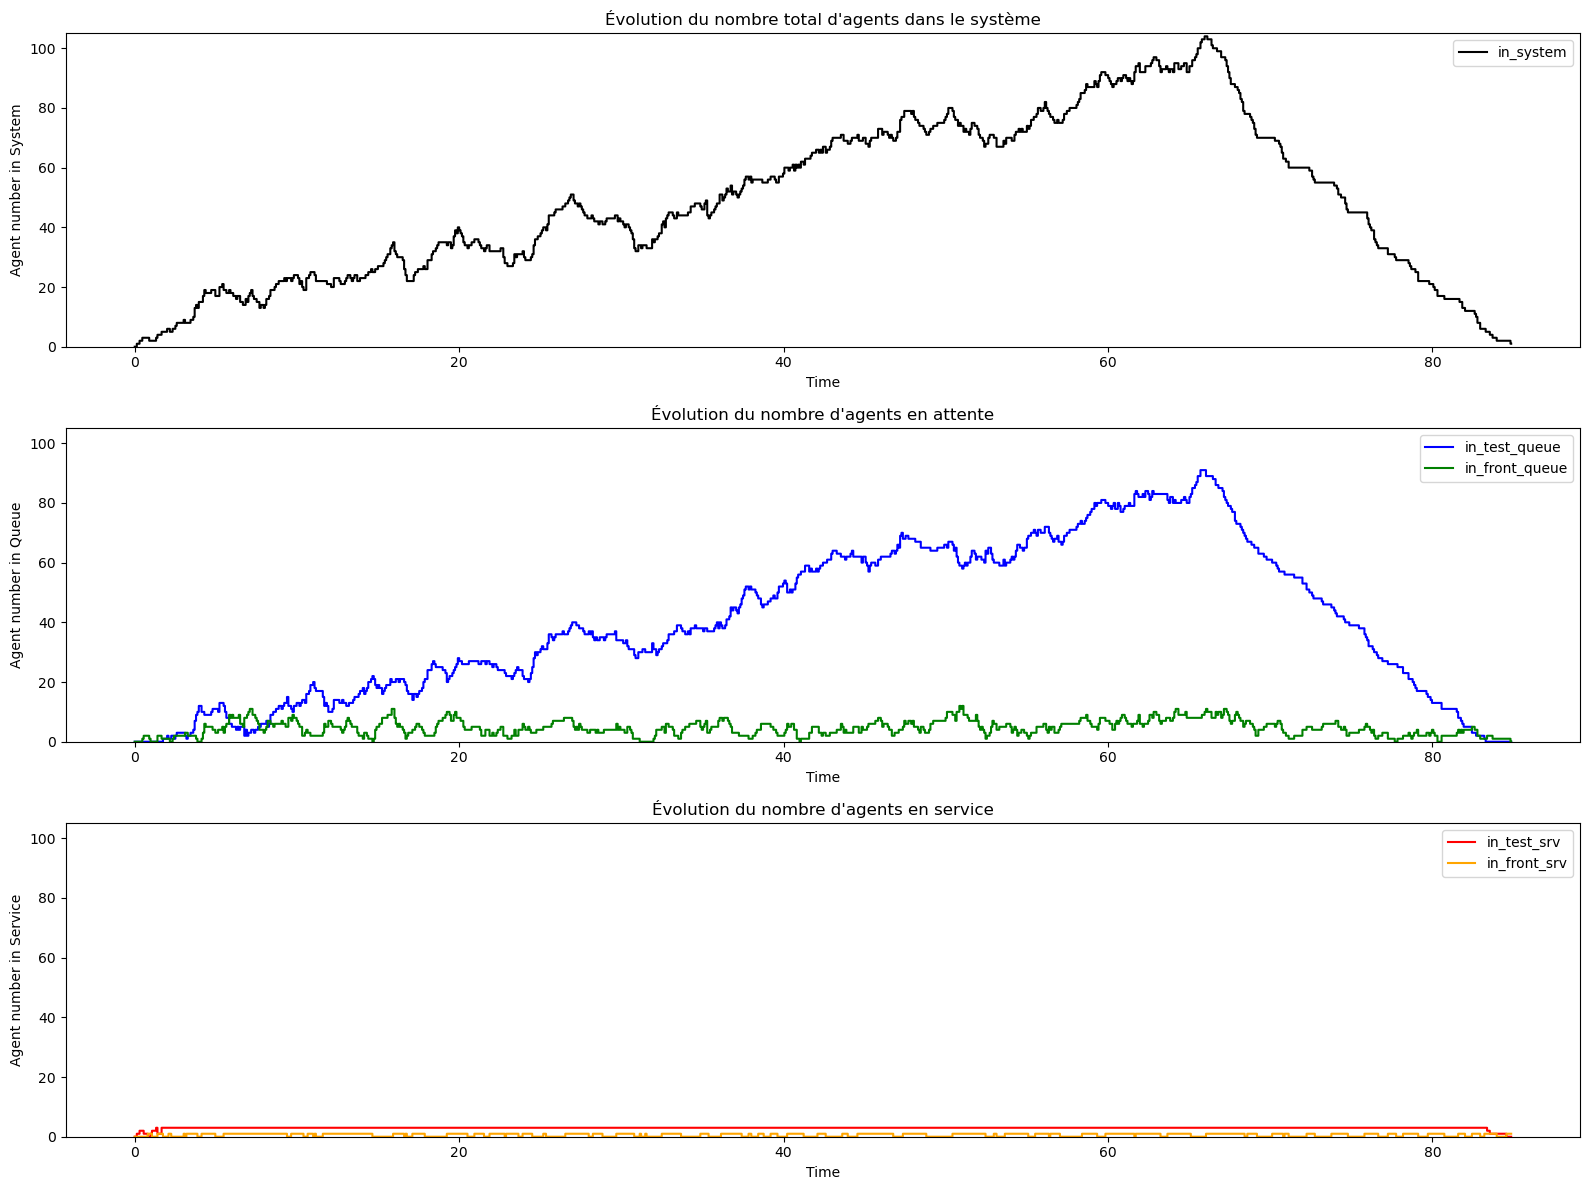

In [372]:
plot_bench(bench)

Cette fois-ci on observe plus de "pics" réguliers mais une accumulation graduelle qui finit éventuellement par redescendre de par le nombre d'agent limité dans le cadre de la simulation. Ce pic correspond à l'"explosion" de la file $F_1$, et si notre simulation était infinie ce pic divergerait vers l'infini, ce qui montre bien l'instabilité de la file $F_1$.

On voit bien que c'est $F_1$ qui explose par le biais du deuxiême graphe, où la courbe bleue montre les agents en attente dans $F_1$.

Ce cas peut être interprété par le fait d'avoir trop d’étudiants qui lancent des tests par rapport à la capacité du système de moulinettage.

### Troisième simulation: instabilité de la file $F_2$
Nous effectuons une troisième simulation avec les paramètres suivants:
- $ \lambda $ = 8
- $ \mu_1 $ = 2
- $ \mu_2 $ = 6
- $ K $ = 5

Ici l'objectif est d'observer le comportement du système dans le cas où la deuxième file $F_2$ agit comme un goulot d'étranglement évident. Cela se traduit par le fait d'avoir $K* \mu_1 > \lambda$ et $\mu_2 < \lambda$.

Autrement dit, le taux de charge de la file $F_1$ $\rho_1 = \frac{\lambda}{K * \mu_1}$ est bien inférieur à 1, mais le taux de charge de la file $F_2$ $\rho_2 = \frac{\lambda}{\mu_2}$ est supérieur à 1.

Note: par soucis de simplicité nous considérons que la file $F_2$ a un processus de Poisson en entrée, mais c'est techniquement pas une loi de Poisson "pure" car l'entrée de $F_2$ correspond à la sortie de $F_1$.

In [376]:
# Waiting system parameters
lambdaa = 8
mu_1 = 2
mu_2 = 6
k = 5

arval_dist = lambda size : rng.exponential(1./lambdaa, size=size)
test_srv_dist = lambda : rng.exponential(1./mu_1)
front_srv_dist = lambda : rng.exponential(1./mu_2)

agent_nb = 500

waterfall = Waterfall(arval_dist,
                 test_srv_dist,
                 front_srv_dist,
                 k,
                 1,
                 test_queue_size=None,
                 front_queue_size=None,
                 test_policy=lambda x:0,
                 front_policy=lambda x: 0,
                 test_size=agent_nb)

In [377]:
waterfall.simulate()
bench, stats = waterfall.timeline()
stats

,value
mean_wait_test,0.231564
mean_wait_front,10.854307
mean_srv_test,0.511962
mean_srv_front,0.165251
blocked_at_test,0.000000
blocked_at_front,0.000000
mean_sojourn,11.761598
test_busy_fraction,0.465000
front_busy_fraction,0.982000


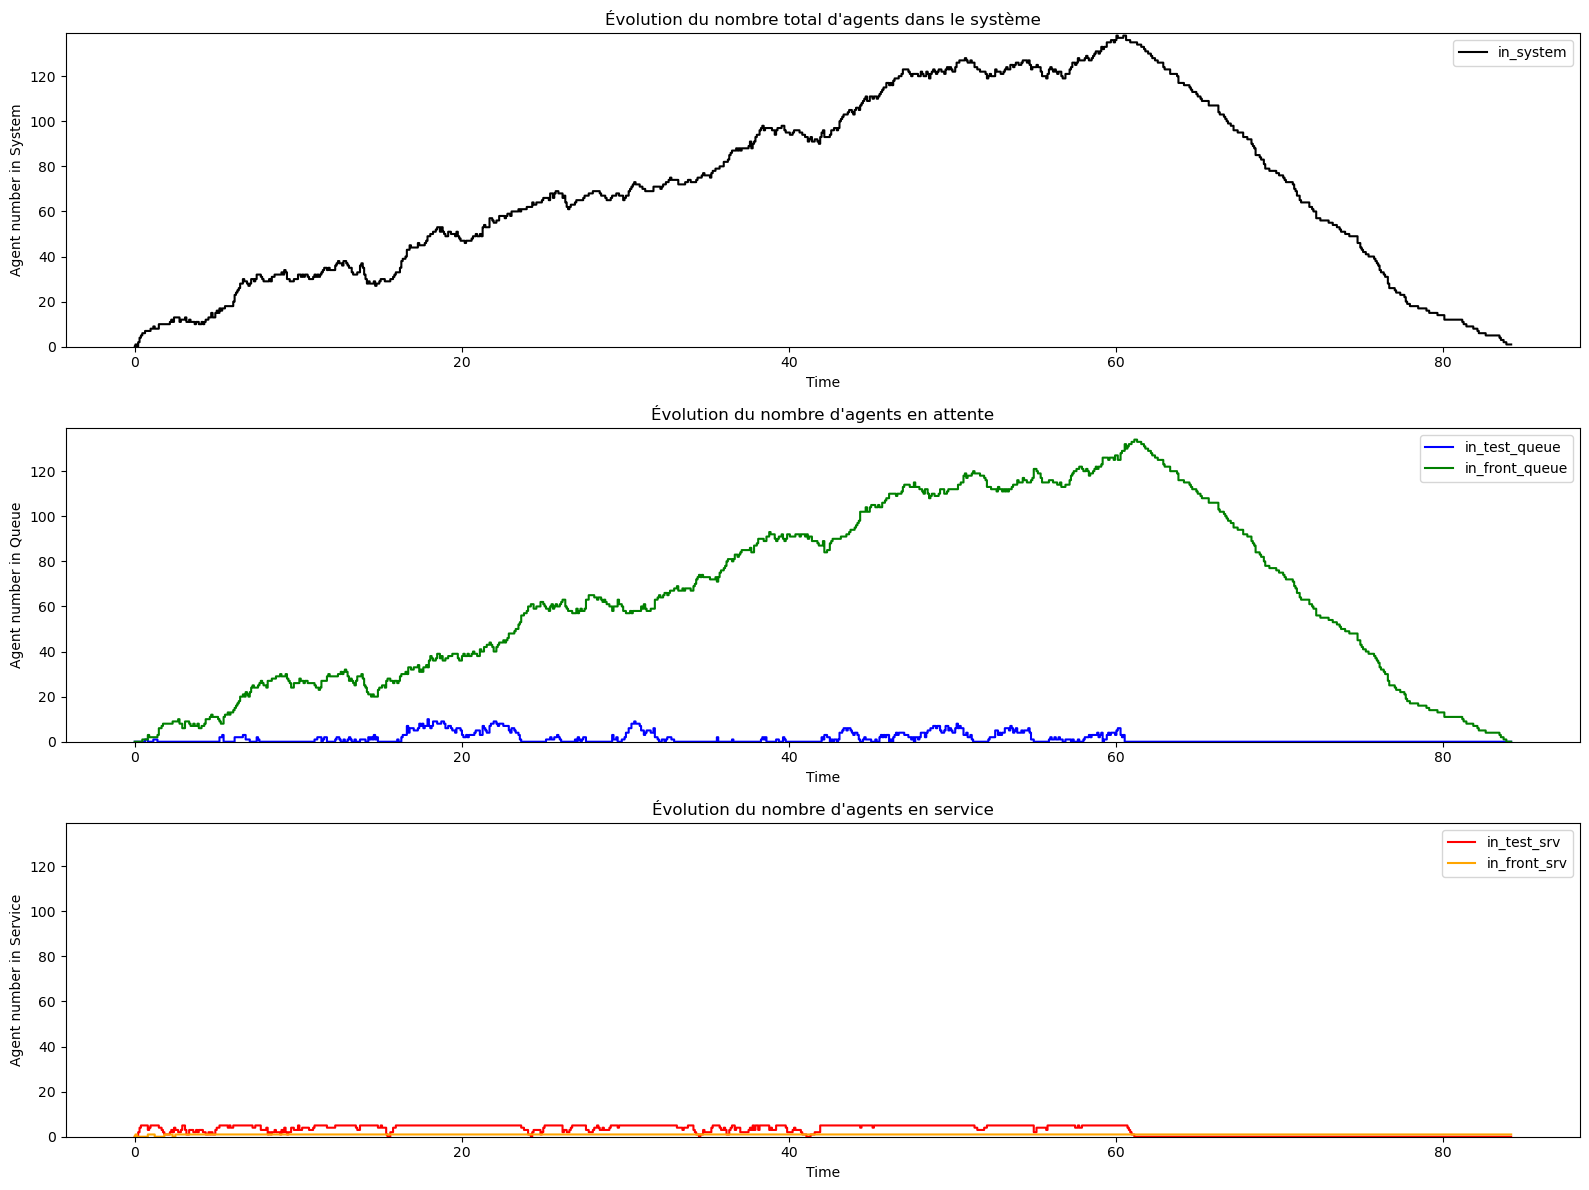

In [378]:
plot_bench(bench)

On observe un comportement similaire à la simulation précédente, sauf que cette fois il s'agit de file d'attente $F_2$ (courbe verte) qui explose.

Ce cas peut être interprété par le fait d'avoir une capacité d'envoi vers le front-end insuffisante par rapport à la capacité de traitement des tests.

## Cas avec files d'attentes finies